# Защита данных клиентов страховой компании

## Получение и изучение данных

###  Поставленная задача и исходные данные

**Заказчик: страховая компания «Хоть потоп»**

**Цель**

Разработать метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, обосновать корректность работы метода.

**Задачи**

- Защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось.
- Подбирать наилучшую модель не требуется.

**Описание данных**

- **Признаки:** пол, возраст и зарплата застрахованного, количество членов его семьи.
- **Целевой признак:** количество страховых выплат клиенту за последние 5 лет.

### Импорт библиотек, установка глобальных настроек

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
pd.options.display.float_format = '{:.3f}'.format

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default='notebook'


import numpy as np

import re

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_spd_matrix

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score

import shap

import random

Для удобства вывода на печать создадим класс для работы с текстом

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

### Обзор и предообработка данных

#### Чтение файлов с данными

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')

#### Изучение общей информации о данных

In [4]:
display(df.info(), df.head(), df.describe())

print(f'\n\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.000,49600.000,1,0
1,0,46.000,38000.000,1,1
2,0,29.000,21000.000,0,0
3,0,21.000,41700.000,2,0
4,1,28.000,26100.000,0,0


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000,5000.000,5000.000,5000.000,5000.000
mean,0.499,30.953,39916.360,1.194,0.148
std,0.500,8.441,9900.084,1.091,0.463
min,0.000,18.000,5300.000,0.000,0.000
25%,0.000,24.000,33300.000,0.000,0.000
50%,0.000,30.000,40200.000,1.000,0.000
75%,1.000,37.000,46600.000,2.000,0.000
max,1.000,65.000,79000.000,6.000,5.000



Количество явных дубликатов: 153



- пропуски отсутствуют
- типы данных корректны
- наименования столбцов на русском языке
- присутствуют явные дубликаты

##  Внесение корректировок на основе наблюдений

### Переименование русскоязычных наименований столбов в англоязычные

In [5]:
df.columns = ['sex', 'age', 'salary', 'relatives', 'insurance']

<ins>Признаки:</ins>
- `sex` - пол клиента,
- `age` - возраст клиента,
- `salary` - зарплата клиента,
- `relatives` - количество членов семьи клиента.

<ins>Целевой признак:</ins>
- `insurance` - количество страховых выплат клиенту за последние 5 лет.

### Удаление явных дубликатов

In [6]:
df = df.drop_duplicates().reset_index(drop=True)
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 0



## Исследовательский анализ данных (EDA)

### Количество/процент клиентов в зависимости от количества страховых выплат

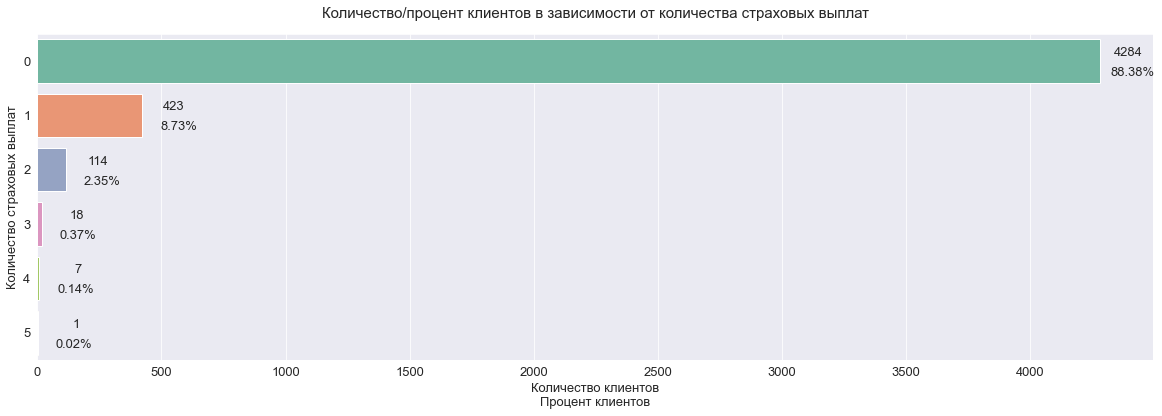

In [7]:
plt.figure(figsize=(20, 6))
plt.title('Количество/процент клиентов в зависимости от количества страховых выплат', fontsize=15, y=1.03)

ax = sns.countplot(data=df, y='insurance', hue='insurance', dodge=False)

plt.xlabel('Количество клиентов\nПроцент клиентов')
plt.ylabel('Количество страховых выплат')
ax.get_legend().remove()

total = len(df)
for p in ax.patches:
        ax.annotate('{:.2f}%'.format(100 * p.get_width()/total),
                    (p.get_x() + p.get_width() +200, p.get_y() + p.get_height()/1.3),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center')
        ax.annotate('%.0f' % p.get_width(),
                    (p.get_x() + p.get_width() +150, p.get_y() + p.get_height()/3.2),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center') 

- основная масса клиентов не получали страховых выплат
- 1, 2 страховые выплаты получили около 10% клиентов
- клиентов с количеством страховых выплат больше двух незначительное количество (<1%)

### Процент клиентов в зависимости от пола и количества членов семьи

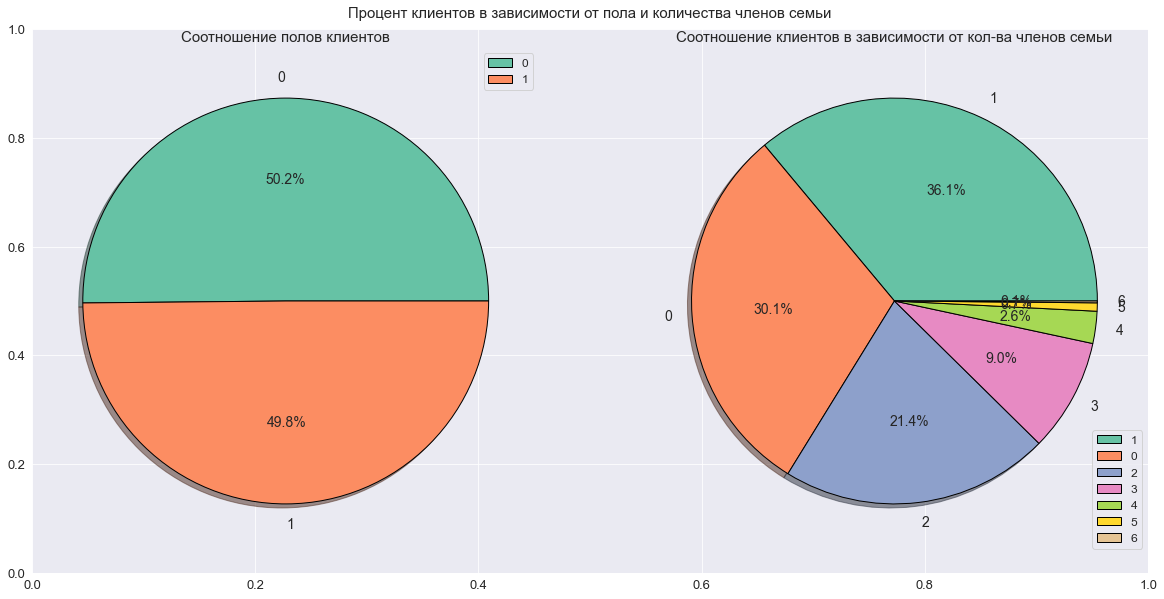

In [8]:
columns = ['sex', 'relatives']
axes = []

fig = plt.figure(figsize=(20, 10))

plt.title('Процент клиентов в зависимости от пола и количества членов семьи', fontsize=15, y=1.01)

titles = ['Соотношение полов клиентов',
          'Соотношение клиентов в зависимости от кол-ва членов семьи']

for i in range(len(columns)):
    axes.append(fig.add_subplot(1, 2, i+1))
    pie_clients=df[columns[i]].value_counts().plot(kind='pie',
                                                   legend=True,
                                                   label='',
                                                   autopct='%1.1f%%',
                                                   title=titles[i],
                                                   shadow=True,
                                                   wedgeprops={'lw':1, 'ls':'-','edgecolor':'k'},
                                                   ax=axes[i],
                                                   fontsize=14)
    pie_clients.legend(fontsize=12)
    axes[i].title.set_size(15)

- соотношение полов равное
- основная масса клиентво с количеством членов семьи от 0 до 2
- клиентов с количеством членов семьи от 3 до 4 около 10%
- клиентов с количеством членов семьи более 4 незначительное количество

### Распределение данных в признаках с непрерывными значениями

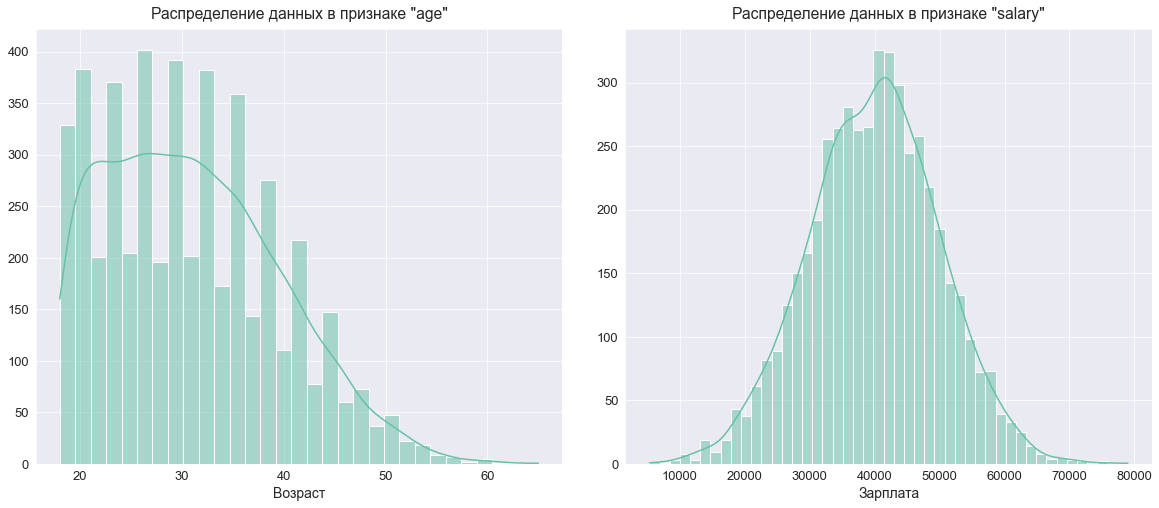

In [9]:
plt.figure(figsize=(20,8))

plt.subplots_adjust(wspace=0.12)

columns = ['age', 'salary']
x_titles = ['Возраст', 'Зарплата']

for i in range(len(columns)):
    fig = plt.subplot(1, 2, i+1)    
    ax = sns.histplot(data=df, x=columns[i], kde=True)
    ax.set(ylabel=None)
    ax.set_title(f'Распределение данных в признаке "{columns[i]}"', pad=10)
    plt.xlabel(x_titles[i], fontsize=14)

- в признаке `age` данные смещены вправо, гистограмма с обрывом слева, что логично, т.к. страхуются совершеннолетние, которые способны оплатить страховку, с приближением к пенсионному возрасту зарплаты падают, страховку могут себе позволить далеко не все
- в признаке `salary` данные имеют нормальное распределение, что должно положительно сказаться на качестве модели

### Матрица рассеяния между признаками

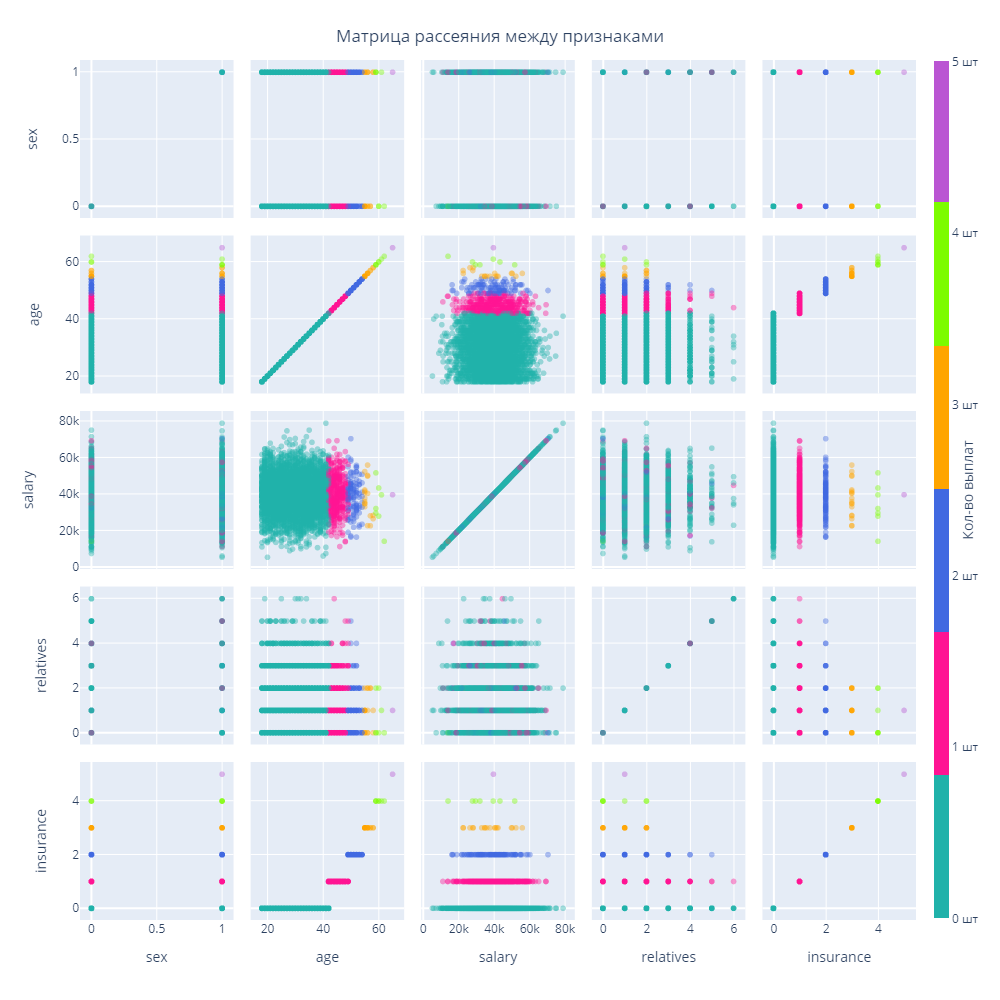

In [10]:
fig = px.scatter_matrix(df, opacity=0.4,
                        color='insurance',
                        color_continuous_scale=[(0, 'lightseagreen'),   (.167, 'lightseagreen'),
                                                (.167, 'deeppink'), (.334, 'deeppink'),
                                                (.334, 'royalblue'),  (.501, 'royalblue'),
                                                (.501, 'orange'),  (.668, 'orange'),
                                                (.668, 'lawngreen'),  (.835, 'lawngreen'),
                                                (.835, 'mediumorchid'),  (1, 'mediumorchid')])
fig.update_layout(title={'text': 'Матрица рассеяния между признаками',
                         'y':0.97,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=1000,
                  height=1000,
                  
                  coloraxis_colorbar=dict(x=1.01,                                        
                                          ticksuffix=" шт",
                                          len=1.02,
                                          thickness=15,
                                          title = dict(text='Кол-во выплат', side='right'),
                                          dtick = 1)
                 )
      
fig.show('png')

- пол закодированный как "0" не получал более 4 страховых выплат
- количество страховых выплат прямопропорционально возрасту:
    - основная возрастная категория - 18-45 лет - не получала выплат,
    - 45-50 лет - получали одну выплату
    - 50-55 лет - 2 и т.д.

### Исследование зависимостей между признаками

Создадим функцию `phik_corr_plot()`,

принимающую на вход:
- `df` - датасет для оценки взаимосвязей.

На выходе функции - тепловые карты взаимосвязей.

In [11]:
def phik_corr_plot(df: pd.DataFrame):
    
    '''Сохраним матрицы зависимостей по значениям коэффициента phik и корреляции Пирсона в отдельные переменные.'''
    
    phik_overview = df.phik_matrix(df.columns)
    correlation = df.corr()
    
    '''Построим тепловые карты взаимосвязей.'''
    
    fig = make_subplots(rows=1, cols=2, subplot_titles = ['Коэффициент Phik', 'Корреляция Пирсона'])

    for f, rel, i  in zip(['fig1', 'fig2'],
                          [phik_overview, correlation],
                          [1, 2]):
    
        locals()[f] = px.imshow(rel, text_auto='.3f') 
    
        fig.add_trace(locals()[f]['data'][0], row=1, col=i)
    
    fig.update_layout(title={'text': 'Сравнение зависимостей между признаками на тепловых картах',
                             'y':0.92,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},                
     
                      coloraxis = dict(colorscale='RdBu', cmid=0),
                      
                      coloraxis_colorbar=dict(x=1.01,
                                              len=1.06,
                                              thickness=15,
                                              title = dict(text='Значение коэффициента', side='right'))
                     )    
    fig.show('png')

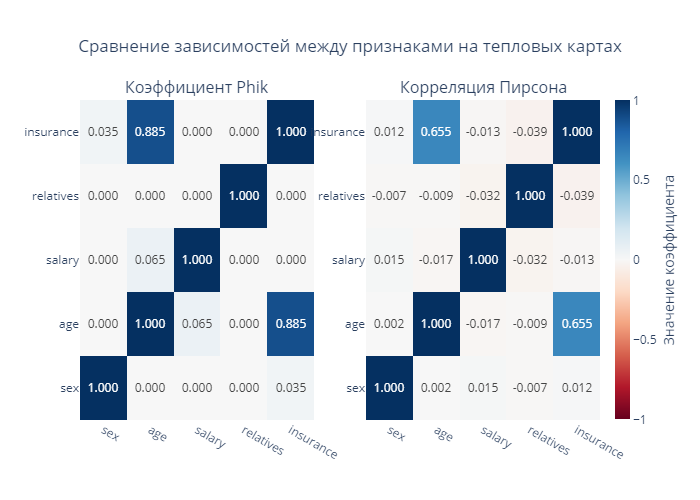

In [12]:
phik_corr_plot(df)

- Графические наблюдения подтвердились коэффициентами взаимосвязей (линейными и нелинейными).
- Более корректно исследовать зависимости в данных по коэффициенту `phik`, т.к. он учитывает и нелинейные взаимосвязи в данных, в отличии от `корреляции Пирсона`.
- Возраст сильно зависит от количества страховых выплат, остальные признаки практически не зависят.
- Взаимосвязи в признаках между собой минимальные, что должно положительно сказаться на качестве модели.

## Неизменность качества модели при умножении признаков на обратимую матрицу

<center>Основные формулы обучения линейной регрессии

|<font size="2">**N**| <font size="2">**Формула**| <font size="2">**Пояснения**  |
| :--- | :---: | :--- |
|<font size="2">1.1|<font size="2">$$a = X\cdot{w}$$|<font size="2">Сокращенная формула вектора предсказаний|
|<font size="2">1.2|<font size="2">$$w = \arg\min_w MSE(X\cdot{w}, y)$$|<font size="2">Формула задачи обучения линейной регрессии для функции потерь $MSE$|
|<font size="2">1.3|<font size="2">$$w = (X^T\cdot{X})^{-1}\cdot{X^T}\cdot{y}$$|<font size="2">Формула минимизации функции потерь|

<center>Где переменные это:

| <font size="2">**Имя переменной**| <font size="2">**Определение**|
| :---: | :--- |
|<font size="2">$$a$$|<font size="2">вектор предсказаний|
|<font size="2">$$X$$|<font size="2">матрица признаков обучающей выборки|
|<font size="2">$$w$$|<font size="2">вектор параметров линейной регрессии, включающий веса и сдвиг предсказания|
|<font size="2">$$\arg\min_w$$|<font size="2">Функция $argmin$ находит минимум и возвращает, при каком аргументе он был достигнут|
|<font size="2">$$MSE$$|<font size="2">Cредняя квадратичная ошибка, от англ. mean squared error, $$MSE={\frac 1N}{\sum_{i=1}^N(предсказание\,модели-правильный\,ответ)^2}$$|
|<font size="2">$$y$$|<font size="2">вектор значений целевого признака для обучающей выборки|
|<font size="2">$$X^T$$|<font size="2">транспонированная матрица - перевнута относительно главной диагонали матрицы, которая идёт из левого верхнего в правый нижний угол (строки матрицы становятся её столбцами, а столбцы — строками)|
|<font size="2">$$(X^T\cdot{X})^{-1}$$|<font size="2">обратная к результату матрица, находится для квадратной матрицы, - матрица $A$ с верхним индексом $-1$, произведение которой на $А$ равно единичной матрице: $$A\cdot{A^{-1}} = A^{-1}\cdot{A} = E,$$ где единичная матрица — это квадратная матрица, на главной диагонали которой стоят единицы, а остальные элементы — нули|

<center> Основные формулы для работы с матрицами:

| <font size="2">**N**| <font size="2">**Формула**|
| :--- | :---: |
|<font size="2">2.1|<font size="2">$${A}\cdot{B} \neq {B}\cdot{A}$$|
|<font size="2">2.2|<font size="2">$$({A}\cdot{B})^{-1} = {B}^{-1}\cdot{A}^{-1}$$|
|<font size="2">2.3|<font size="2">$$({A}\cdot{B})^T = {B}^T\cdot{A}^T$$|    
|<font size="2">2.4|<font size="2">$$A\cdot{A^{-1}} = A^{-1}\cdot{A} = E$$ | 
|<font size="2">2.5|<font size="2">$${A}\cdot{E} = {E}\cdot{A} = A$$| 
    
    

<center> Обоснование неизменности качества линейной регрессии при умножении признаков на обратимую матрицу

|<font size="2">**N**| <font size="2">**Формула**| <font size="2">**Пояснения**  |
| :--- | :---: | :--- |
|<font size="2">3.1|<font size="2">$$w' = ((X\cdot{P})^T\cdot{X}\cdot{P})^{-1}\cdot{(X\cdot{P})^T}\cdot{y}$$|<font size="2">Вычислим новый вектор параметров $w'$.<br>В формуле 1.3 домножим матрицу признаков на обратимую случайную квадратную матрицу $P$|
|<font size="2">3.2|<font size="2">$$w' = ({P}^T\cdot{X}^T\cdot{X}\cdot{P})^{-1}\cdot{P}^T\cdot{X}^T\cdot{y}$$|<font size="2">Применим формулу 2.3|
|<font size="2">3.3|<font size="2">$$w' = {P}^{-1}\cdot({X}^T\cdot{X})^{-1}\cdot({P}^T)^{-1}\cdot{P}^T\cdot{X}^T\cdot{y}$$|<font size="2">Применим формулу 2.2|
|<font size="2">3.4|<font size="2">$$w' = {P}^{-1}\cdot({X}^T\cdot{X})^{-1}\cdot{X}^T\cdot{y}$$|<font size="2">Применим формулы 2.4 и 2.5|
|<font size="2">3.5|<font size="2">$$w' = {P}^{-1}\cdot{w}$$|<font size="2">Применим формулу 1.3|
|<font size="2">3.6|<font size="2">$$a' = X\cdot{P}\cdot{w'}$$|<font size="2">Вычислим новый вектор предсказаний. В формуле 1.1 домножим матрицу признаков на обратимую матрицу $P$ и на новый вектор параметров $w'$|
|<font size="2">3.7|<font size="2">$$a' = X\cdot{P}\cdot{P}^{-1}\cdot{w}$$|<font size="2">Применим формулу 3.5|
|<font size="2">3.8|<font size="2">$$a' = X\cdot{w}$$|<font size="2">Применим формулы 2.4 и 2.5|    
|<font size="2">3.9|<font size="2">$$a' = a$$|<font size="2">Применим формулу 1.1| 

Векторы предсказаний равны, следовательно качество линейной регрессии при умножении признаков на обратимую матрицу не изменится.

## Алгоритм преобразования данных для решения задачи

<center> Алгорим преобразования данных

|<font size="2">**N**| <font size="2">**Формула**| <font size="2">**Пояснения**  |
| :--- | :---: | :--- |
|<font size="2">1|<font size="2">$$features = df.drop('insurance', axis=1)$$ $$target = df['insurance']$$|<font size="2">Создадим переменные для признаков и целевого признака|
|<font size="2">2|<font size="2">$$P = make\_spd\_matrix(n\_dim=4, random\_state=42)$$ $$np.linalg.inv(P)$$|<font size="2">Создадим случайную квадратную матрицу, проверим её на обратимость и возможность восстановления данных|
|<font size="2">3|<font size="2">$$X' = X\cdot{P}$$|<font size="2">Определим новую матрицу признаков $X'$ - матрица признаков  $X$  размера  $mxn$  умножается на случайную квадратную обратимую матрицу $P$ размера  $nxn$<br> $$(в\;коде features\_p = features @ P)$$|
|<font size="2">4|<font size="2">$$train = 0.75\cdot{df}$$ $$test = 0.25\cdot{df}$$|<font size="2">Разделим данные на обучающую и тестовую выборки. Обучим модель на обучающей, проверим качество на тестовой.|
|<font size="2">5|<font size="2">$$w' = \arg\min_{w'} MSE({X'}\cdot{w'}, y)$$|<font size="2">Формула задачи обучения линейной регрессии для функции потерь $MSE$ при новой матрице признаков $X'$ и новом векторе параметров $w'$|    
|<font size="2">6|<font size="2">$$w' = ((X\cdot{P})^T\cdot{X}\cdot{P})^{-1}\cdot{(X\cdot{P})^T}\cdot{y}$$|<font size="2">Формула минимизации функции потерь при новой матрице признаков $X'$ и новом векторе параметров $w'$|    
|<font size="2">7|<font size="2">$$a' = X'\cdot{w'}$$<br> $$a'=X\cdot{P}\cdot((X\cdot{P})^T\cdot{X}\cdot{P})^{-1}\cdot{(X\cdot{P})^T}\cdot{y}$$|<font size="2">Сокращенная формула вектора предсказаний при новой матрице признаков $X'$ и новом векторе параметров $w'$|
|<font size="2">8|<font size="2">$$R2=1-{{MSE_{модели}}\over{MSE_{среднего}}}$$|<font size="2">Для оценки качества определим значение метрики $R2$ (коэффициент детерминации). Увеличение метрики означает прирост качества модели.|

Обоснование неизменности качества линейной регрессии приведено в предыдущей главе.

## Реализация алгоритма и проверка качества

### Создание переменных для признаков и целевого признака

In [13]:
features = df.drop('insurance', axis=1)
target = df['insurance']

### Создание случайной квадратной матрицы

1. Сгенерируем случайную квадратную обратимую матрицу при помощи функции `make_spd_matrix()` из библиотеки `sklearn.datasets`.
2. Проверку на обратимость выполним при помощи функции `linalg.inv()` из библиотеки `numpy`.
3. Размер матрицы 4х4, т.к. далее необходимо выполнить матричное умножение, ширина исходной матрицы должна быть равна высоте случайной. В исходной матрице 4 столбца (ширина 4), значит высота (и ширина) квадратной матрицы также 4.

In [14]:
P = make_spd_matrix(n_dim=4, random_state=42)
try:
    np.linalg.inv(P)
    print('Матрица обратима')
except:
    print('Матрица не обратима')

Матрица обратима


### Умножение матриц

1. Умножим матрицу признаков на случайную матрицу и сохраним результат в отдельную переменную.

In [15]:
features_p = features @ P
features_p.head()

,0,1,2,3
0,23135.223,-38043.068,43377.273,-47839.267
1,17711.373,-29118.930,33220.793,-36628.323
2,9785.355,-16086.483,18356.643,-20237.795
3,19459.930,-32005.353,36477.232,-40236.494
4,12169.462,-20008.366,22821.333,-25165.491


2. Признаки зашифрованы.

### Проверка результатов шифрования

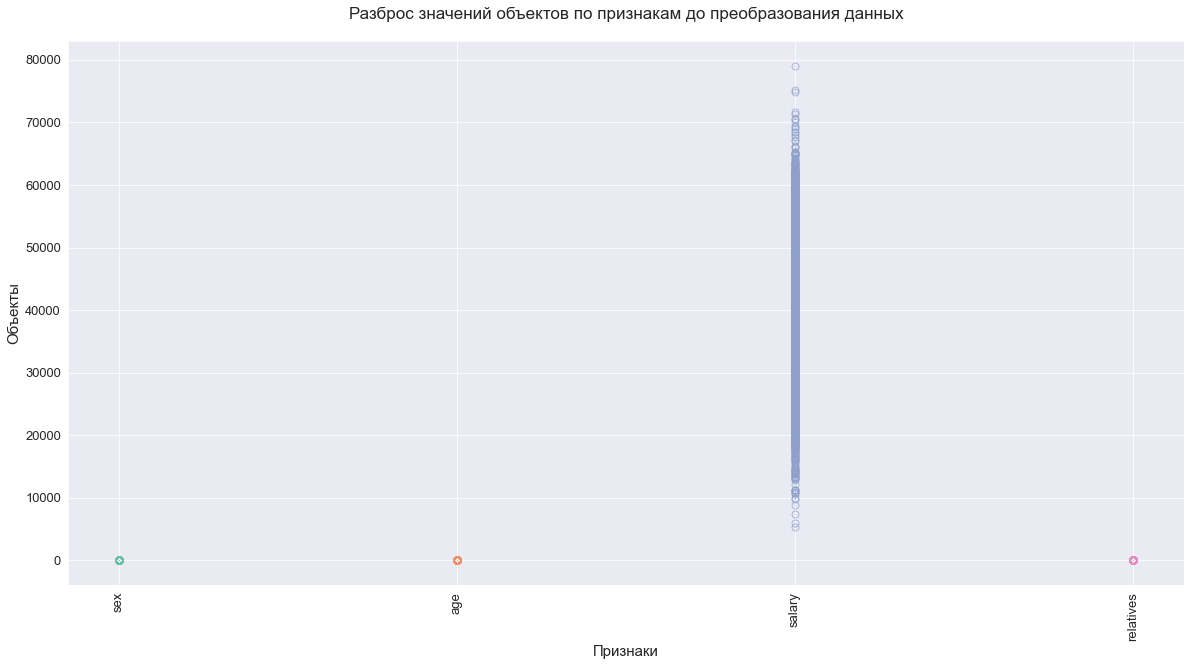

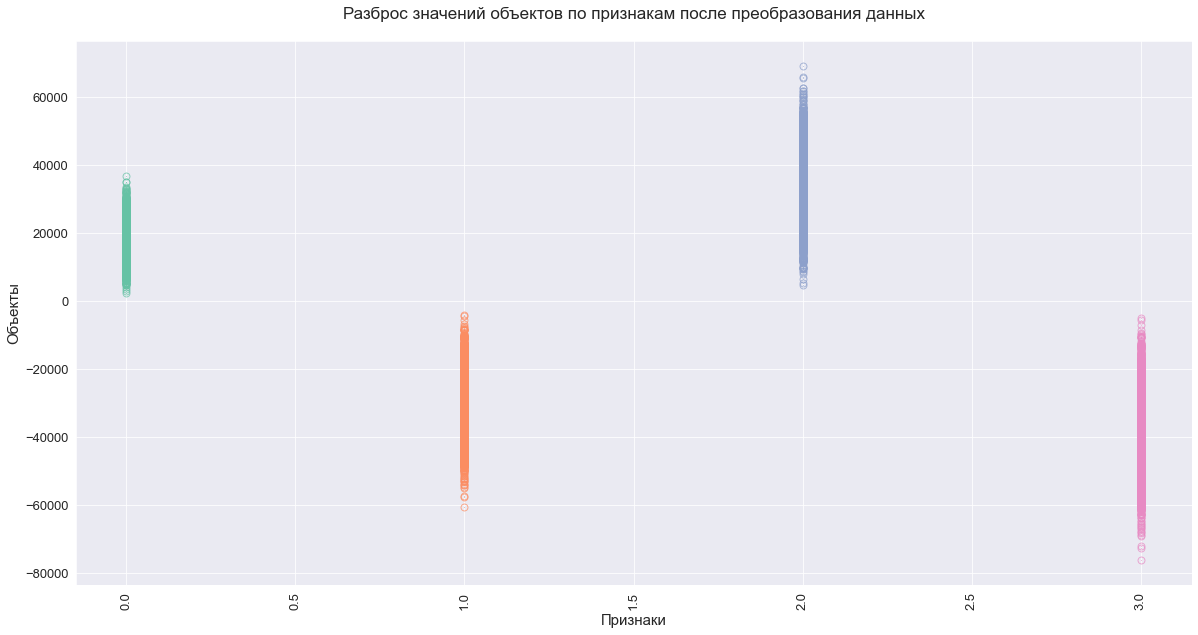

In [16]:
selection = [features, features_p]
title = ['Разброс значений объектов по признакам до преобразования данных',
         'Разброс значений объектов по признакам после преобразования данных']

for i in range(2):

    fig, ax = plt.subplots(figsize=(20,10))
    
    for column in list(selection[i].columns):
        ax.scatter([column]*len(selection[i]), selection[i][column], alpha=.7, linewidth=7, s = 1)
    
    ax.set_xlabel('Признаки', fontsize=15)
    ax.set_ylabel('Объекты', fontsize=15)
    plt.title(title[i], fontsize=17, y=1.03)
    plt.xticks(rotation = 90)
    plt.show()

### Матрица рассеяния между признаками после преобразования данных

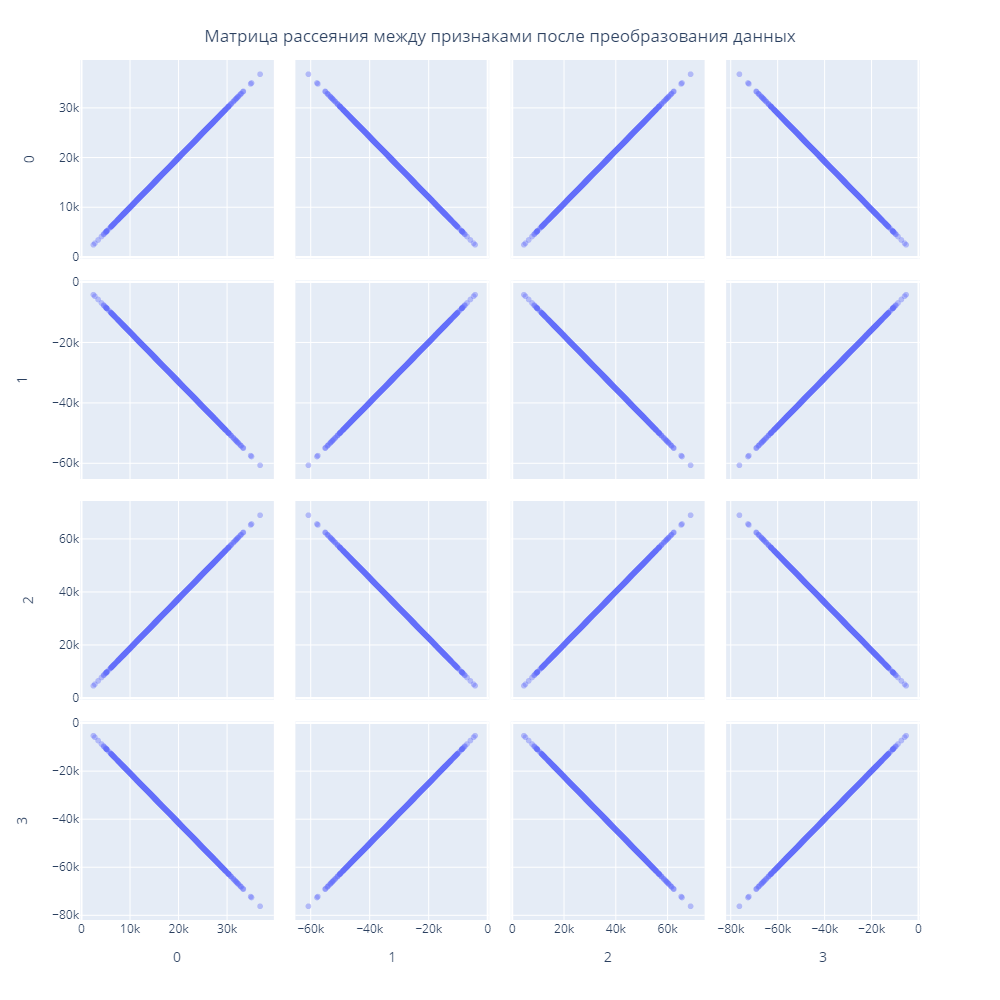

In [17]:
fig = px.scatter_matrix(features_p, opacity=0.4,)

fig.update_layout(title={'text': 'Матрица рассеяния между признаками после преобразования данных',
                         'y':0.97,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=1000,
                  height=1000)
      
fig.show('png')

Довольно сильные взаимосвязи. Посмотрим на коэффициенты взаимосвязи ниже.

### Исследование зависимостей между признаками после преобразования данных

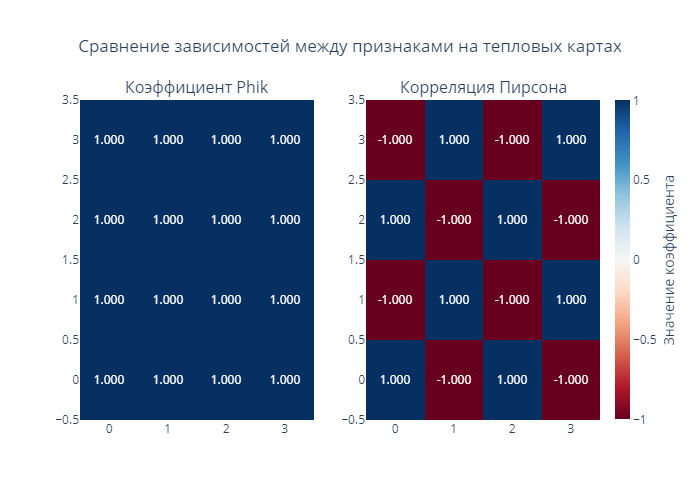

In [18]:
phik_corr_plot(features_p)

Такой эффект появился из-за операции матричного умножения.

При матричном умножении по двум матрицам строится третья. Она состоит из скалярных произведений строк первой матрицы на столбцы второй. Так результатом произведения $i$-й строки матрицы $A\;(A_i)$ на j-й столбец матрицы $B\;(B_j)$ станет элемент матрицы $C$ c индексами $i, j\;(C_{ij})$:

$C_{ij}=(A_i,B_j)$

а именно:

$
\begin{pmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
a_{31} & a_{32}  
\end{pmatrix}x\begin{pmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22} \\  
\end{pmatrix} = \begin{pmatrix}
a_{11}*b_{11}+a_{12}*b_{21} & a_{11}*b_{12}+a_{12}*b_{22}  \\
a_{21}*b_{11}+a_{22}*b_{21} & a_{21}*b_{12}+a_{22}*b_{22}  \\
a_{31}*b_{11}+a_{32}*b_{21} & a_{31}*b_{12}+a_{32}*b_{22}   
\end{pmatrix}$

Т.к. произведение скалярное (числовое), то взаимосвязи становятся линейными, но это искусственно созданная взаимосвязь и не говорит о мультиколлинеарности.

### Проверка новой матрицы признаков на возможность восстановления данных

Исходные признаки

In [19]:
features.head()

,sex,age,salary,relatives
0,1,41.000,49600.000,1
1,0,46.000,38000.000,1
2,0,29.000,21000.000,0
3,0,21.000,41700.000,2
4,1,28.000,26100.000,0


Преобразованные признаки, умноженные на обратную к случайной матрицу

In [20]:
(features_p @ np.linalg.inv(P)).head()

,0,1,2,3
0,1.000,41.000,49600.000,1.000
1,-0.000,46.000,38000.000,1.000
2,-0.000,29.000,21000.000,0.000
3,-0.000,21.000,41700.000,2.000
4,1.000,28.000,26100.000,0.000


Результаты идентичны.

### Деление данных на обучающие и тестовые выборки

- До шифрования

In [21]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            random_state=12345,
                                                                            test_size=0.25)

- После шифрования

In [22]:
features_p_train, features_p_test = train_test_split(features_p,
                                                     random_state=12345,
                                                     test_size=0.25)

### Проверка результатов деления на выборки

Проверка результатов деления на выборки

размер выборки features_train : (3635, 4)
размер выборки features_test : (1212, 4)
размер выборки target_train : (3635,)
размер выборки target_test : (1212,)
размер выборки features_p_train : (3635, 4)
размер выборки features_p_test : (1212, 4)


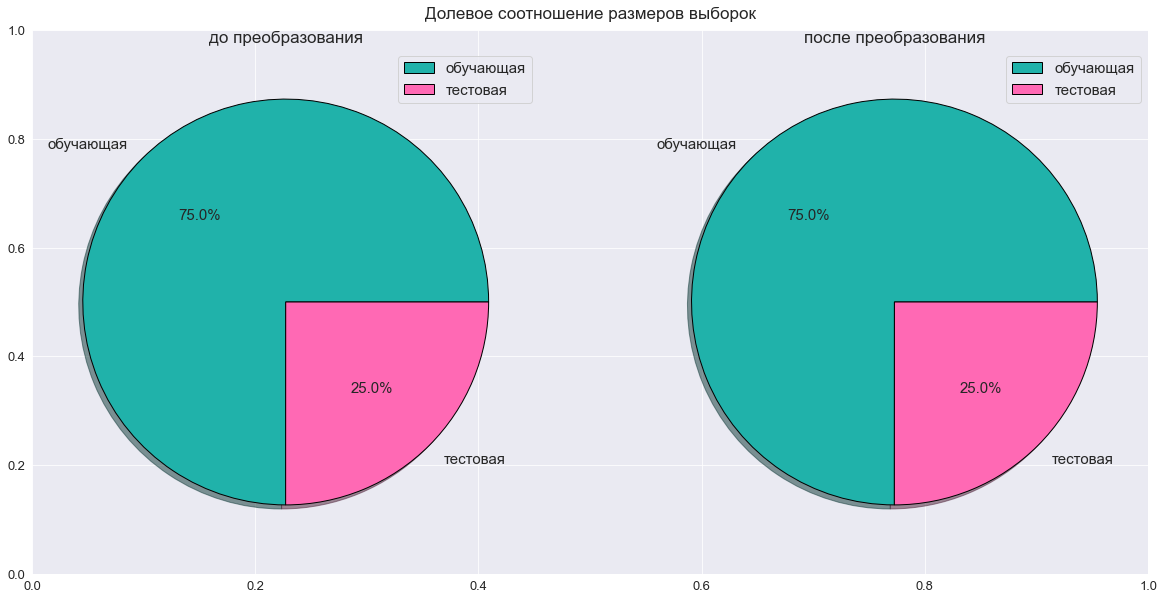

In [23]:
print(color.BOLD+color.UNDERLINE+'Проверка результатов деления на выборки\n'+color.END)
for col in ['features_train', 'features_test', 'target_train',
            'target_test', 'features_p_train', 'features_p_test']:
    print(f'размер выборки {col} : {locals()[col].shape}')


selections = pd.Series({'обучающая': len(features_train),
                        'тестовая': len(features_test)})

selections_p = pd.Series({'обучающая': len(features_p_train),
                          'тестовая': len(features_p_test)})

select_list=[selections, selections_p]

axes = []

fig = plt.figure(figsize=(20, 10))

plt.title('Долевое соотношение размеров выборок', fontsize=17, y=1.01)

titles = ['до преобразования',
          'после преобразования']

for i in range(len(select_list)):
    
    axes.append(fig.add_subplot(1, 2, i+1))
    
    pie_selections=select_list[i].plot(kind='pie',
                                       legend=True,
                                       label='',
                                       autopct='%1.1f%%',
                                       title=titles[i],
                                       shadow=True,
                                       wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"},
                                       colors = ['lightseagreen', 'hotpink'],
                                       fontsize=15)

    pie_selections.legend(fontsize=15)
    axes[i].title.set_size(17)

### Программирование алгоритма преобразования данных

Запрограммируем вышепредложенный алгоритм, применив матричные операции.

Создадим класс `myLinearRegression`.

| <font size="2">**Формула**| <font size="2">**Пояснения**  |
| :--- | :--- |
|<font size="1">$$X = np.concatenate((np.ones((train\_features.shape[0], 1)), train\_features), axis=1)$$|<font size="2">В обучающую выборку добавлен единичный столбец.|    
|<font size="2">$$w =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)$$|<font size="2">Сокращённая запись формулы линейной регрессии.<br><br>Транспонированная матрица признаков умножается на себя: ***X.T.dot(X)***.<br><br>Вычисляется обратная к результату матрица при помощи функции ***numpy.linalg.inv(...)*** (от англ. linear algebra, «линейная алгебра»; invert, «обратить»), также она поможет проверить матрицу на обратимость: если матрица необратима, будет обнаружена ошибка.<br><br>Обратная умножается на транспонированную матрицу признаков: ***... .dot(X.T)***.<br><br>Результат умножается на вектор значений целевого признака: ***... .dot(y)***.|
    
    
    
    
    

In [24]:
class MyLinearRegression:
    
    '''Метод fit() для обучения линейной регрессии''' 
    def fit(self, train_features, train_target):
        '''Добавим в обучающую выборку  единичный столбец'''        
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        
        '''Вектор значений целевого признака для обучающей выборки'''        
        y = train_target
        
        '''Сокращённая запись формулы линейной регрессии'''
        w =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        
        '''Вектор весов (w; от англ. weights)'''
        self.w = w[1:]
        
        '''Величина сдвига предсказания'''
        self.w0 = w[0]

    '''Метод predict() для вычисления предсказания линейной регрессии'''
    def predict(self, test_features):
        
        '''вектор предсказаний'''
        return test_features.dot(self.w) + self.w0

### Функция машинного обучения

<ins>Создадим функцию `model_metrics()`.<ins/>

На входе функции:
- `model` - модель с необходимыми параметрами

На выходе функции:
- `model` - модель
- `R2` - значение метрики R2 - показателя качества
- `predictions` - предсказания на тестовой выборке

In [25]:
def model_metrics(model: 'ModelRegressor', features_train: pd.DataFrame, features_test: pd.DataFrame):    
    model.fit(features_train, target_train) # обучение модели
    predictions = model.predict(features_test) # предсказания модели
    R2 = r2_score(target_test, predictions) # вычисление R2
    print(f'\033[1m\033[4mМодель: {model}\033[0m')
    print(f'Значение метрики R2: {R2:.3f}')
    
    return model, R2, pd.Series(predictions)

### Качество модели до преобразования

#### Baseline

- Протестируем функцию на константной модели `DummyRegressor`.
- Примем значение метрики R2 константной модели за исходную точку (baseline).
- При качестве модели ниже baseline модель признаётся невменяемой.

In [26]:
model_dummy, r2_dummy, pred_dummy = model_metrics(DummyRegressor(strategy='median'), features_train, features_test)

Модель: DummyRegressor(strategy='median')
Значение метрики R2: -0.103


#### Модель MyLinearRegression

In [27]:
model_my_linear, r2_my_linear, pred_my_linear = model_metrics(MyLinearRegression(), features_train, features_test)

Модель: <__main__.MyLinearRegression object at 0x0000000027DA1760>
Значение метрики R2: 0.423


<ins>Создадим функцию `plot_model_param()`.<ins/>

На входе функции:
- `model` - модель с необходимыми параметрами

Функция выводит на экран значения весов и сдвига. 

In [28]:
def plot_model_param(model: 'ModelRegressor'):
    
    try:
        weight = model.w
        shift = model.w0
    except:
        weight = model.coef_
        shift = model.intercept_ 
        
    print('Веса:  "sex"  {:.3f}, "age" {:.3f}, "salary" {:.3f}, "relatives" {:.3f}'.format(*weight))
    print(f'Сдвиг предсказания: {shift:.3f}')
    
    return weight, shift            

In [29]:
w_my_linear, w0_my_linear = plot_model_param(model_my_linear)

Веса:  "sex"  0.015, "age" 0.036, "salary" 0.000, "relatives" -0.012
Сдвиг предсказания: -0.977


#### Модель LinearRegression из библиотеки sklearn

In [30]:
model_linear, r2_linear, pred_linear = model_metrics(LinearRegression(), features_train, features_test)

Модель: LinearRegression()
Значение метрики R2: 0.423


In [31]:
w_linear, w0_linear = plot_model_param(model_linear)

Веса:  "sex"  0.015, "age" 0.036, "salary" 0.000, "relatives" -0.012
Сдвиг предсказания: -0.977


### Качество линейной регрессии после преобразования

#### Baseline

In [32]:
model_dummy_p, r2_dummy_p, pred_dummy_p  = model_metrics(DummyRegressor(strategy='median'), features_p_train, features_p_test)

Модель: DummyRegressor(strategy='median')
Значение метрики R2: -0.103


#### Модель MyLinearRegression

In [33]:
model_my_linear_p, r2_my_linear_p, pred_my_linear_p = model_metrics(MyLinearRegression(), features_p_train, features_p_test)

Модель: <__main__.MyLinearRegression object at 0x0000000027DCD640>
Значение метрики R2: 0.423


In [34]:
w_my_linear_p, w0_my_linear_p = plot_model_param(model_my_linear_p)

Веса:  "sex"  0.048, "age" 0.076, "salary" -0.006, "relatives" -0.043
Сдвиг предсказания: -0.977


#### Модель LinearRegression из библиотеки sklearn

In [35]:
model_linear_p, r2_linear_p, pred_linear_p = model_metrics(LinearRegression(), features_p_train, features_p_test)

Модель: LinearRegression()
Значение метрики R2: 0.423


In [36]:
w_linear_p, w0_linear_p = plot_model_param(model_linear_p)

Веса:  "sex"  0.048, "age" 0.076, "salary" -0.006, "relatives" -0.043
Сдвиг предсказания: -0.977


### Сравнение результатов

#### Сравнение качества моделей

Метрики качества моделей до и после преобразования сохраним в датафрейм `r2_df`:
- индексы (`model`) - наименование модели
- `r2` - метрика R2 до преобразования
- `r2_p` - метрика R2 после преобразования

In [37]:
model_list = ['dummy','my_linear','linear']

r2_list = [r2_dummy, r2_my_linear, r2_linear] 
r2_p_list = [r2_dummy_p, r2_my_linear_p, r2_linear_p]

r2_df = pd.DataFrame({'model': model_list,
                        'r2': r2_list,
                        'r2_p': r2_p_list}).set_index('model')

Сравним качество графически.

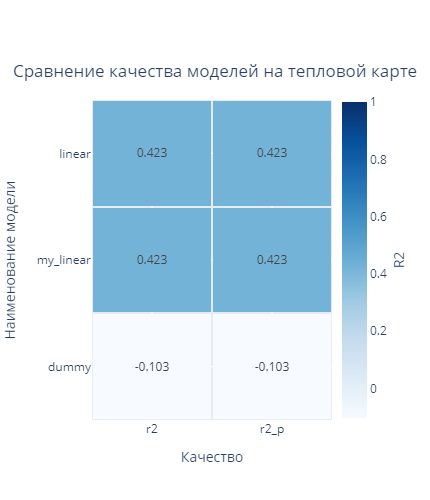

In [38]:
heat = go.Heatmap(z = r2_df,
                  x = r2_df.columns,
                  y = r2_df.index,
                  zmin = r2_df['r2'].min(), 
                  zmax = 1,
                  texttemplate='%{z:.3f}',
                  xgap = 2,
                  ygap = 2,
                  colorscale = 'Blues',
                  colorbar = dict(title='R2', titleside='right', len=1.05, thickness=25, x=1.0))

fig=go.Figure(data=[heat])

fig.update_layout(title={'text': 'Сравнение качества моделей на тепловой карте',
                         'y':0.87,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},                  
                  width = 430,
                  height = 500,                  
                  xaxis_title='Качество',
                  yaxis_title='Наименование модели',
                  autosize = False)
fig.show('png')

- качество до и после преобразования одинаково
- созданный класс модели линейной регрессии и модель линейной регрессии из библиотеки sklearn показывают аналогичное качество, лучше baseline

#### Сравнение параметров линейной регрессии (весов и сдвига предсказания)

Добавим сдвиг предсказаний в массив (вектор) весов. Сохраним результаты в отдельных переменных.

In [39]:
w_w0_my_linear = np.append(w_my_linear, w0_my_linear)
w_w0_linear = np.append(w_linear, w0_linear)
w_w0_my_linear_p = np.append(w_my_linear_p, w0_my_linear_p)
w_w0_linear_p = np.append(w_linear_p, w0_linear_p)

Создадим список параметров моделей.

In [40]:
param_list = ['w_sex', 'w_age', 'w_salary', 'w_relatives', 'w0']

Веса и сдвиг моделей до и после преобразования сохраним в датафрейм `w_df`:
- индексы (`parameters`) - наименование параметров (весов и сдвига)
- `my_linear` - созданный класс модели линейной регрессии до преобразования
- `linear` - модель линейной регрессии из библиотеки sklearn до преобразования
- `my_linear_p` - созданный класс модели линейной регрессии после преобразования
- `linear_p` - модель линейной регрессии из библиотеки sklearn после преобразования

In [41]:
w_df = pd.DataFrame({'my_linear'  : w_w0_my_linear,
                     'linear'     : w_w0_linear,
                     'my_linear_p': w_w0_my_linear_p,
                     'linear_p'   : w_w0_linear_p,
                     'parameters' : param_list}).set_index('parameters')

Сравним параметры графически.

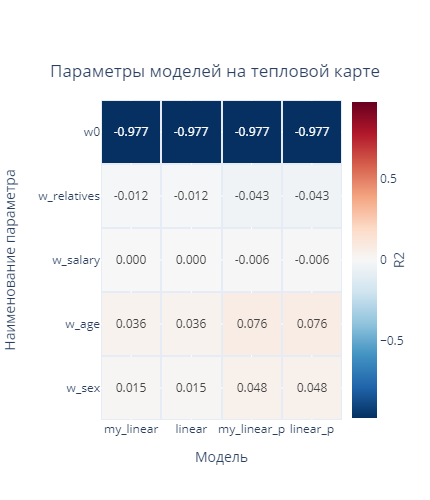

In [42]:
heat = go.Heatmap(z = w_df,
                  x = w_df.columns,
                  y = w_df.index,
                  zmid=0,
                  texttemplate='%{z:.3f}',
                  xgap = 2,
                  ygap = 2,
                  colorscale = 'RdBu_r',
                  colorbar = dict(title='R2', titleside='right', len=1.05, thickness=25, x=1.0))

fig=go.Figure(data=[heat])

fig.update_layout(title={'text': 'Параметры моделей на тепловой карте',
                         'y':0.87,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},              
                  width = 430,
                  height = 500,                  
                  xaxis_title='Модель',
                  yaxis_title='Наименование параметра',
                  autosize = False)
fig.show('png')

- веса (w) до и после преобразования отличаются
- сдвиг (w0) до и после преобразования одинаков
- созданный класс модели линейной регрессии и модель линейной регрессии из библиотеки sklearn вычисляют аналогичные веса и сдвиг

#### Сравнение предсказаний

Сравним предсказания, построив гистограммы распределения значений предсказаний на одном графике.

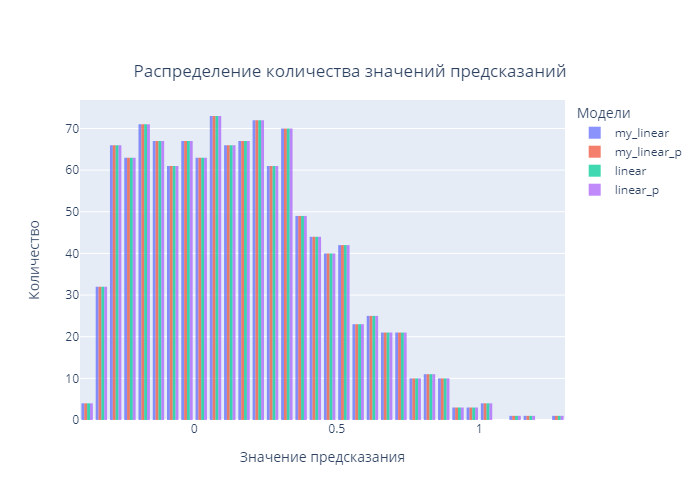

In [43]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=pred_my_linear, name='my_linear'))
fig.add_trace(go.Histogram(x=pred_my_linear_p, name='my_linear_p'))
fig.add_trace(go.Histogram(x=pred_linear, name='linear'))
fig.add_trace(go.Histogram(x=pred_linear_p, name='linear_p'))

fig.update_traces(opacity=0.75)

fig.update_layout(title={'text': 'Распределение количества значений предсказаний',
                         'y':0.87,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  legend_title=dict(text='Модели'),
                  
                  xaxis_title='Значение предсказания',
                  yaxis_title='Количество')

fig.show('png')

- распределения идентичны, как и было доказано ранее значения вектора предсказаний неизменны до и после преобразования
- созданный класс модели линейной регрессии и модель регрессии из библиотеки sklearn вычислят аналогичные предсказания

## Визуализация результатов машинного обучения

### Сравнение распределений данных между целевым признаком и предсказаниями

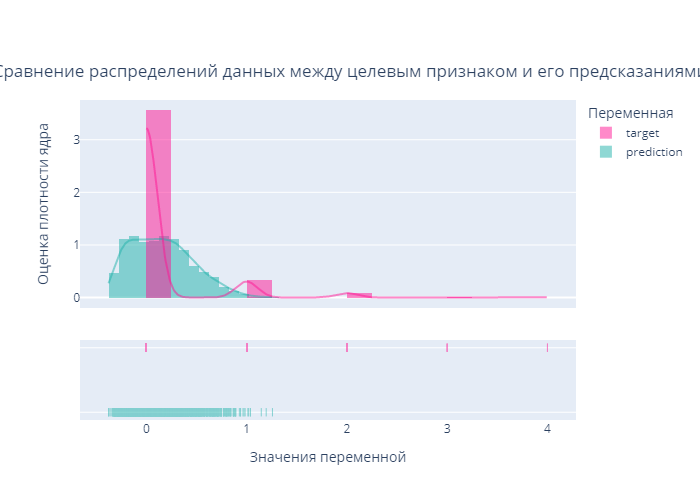

In [44]:
hist_data = [pred_linear, target_test]

group_labels = ['prediction', 'target']
colors = ['lightseagreen', 'deeppink']

fig = ff.create_distplot(hist_data, group_labels, show_hist=True, colors=colors, bin_size=[.1, .25])

fig.update_layout(title={'text': 'Сравнение распределений данных между целевым признаком и его предсказаниями',
                         'y':0.87,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  legend_title=dict(text='Переменная'),
                  
                  xaxis_title='Значения переменной',
                  yaxis_title='Оценка плотности ядра')

fig.update_traces(opacity=0.5)

fig.show('png')

- Смещение данных относительно нормального распределения отрицательно влияет на качество модели.
- Значения целевого признака имеют более высокий пик, т.к. представлено небольшое количество уникальных значений в целевом признаке и большинство значений это 0.
- Предсказания имеют больший разброс, т.к. вычисляются по формуле линейной регрессии и зависят от значений признаков, среди которых есть непрерывные переменные.
- Большинство значений предсказаний находятся в диапазоне от -0.5 до 0.5.

### Корректировка вычисления вектора предсказаний

На основе наблюдений, сделанных выше, сопоставляя их с исходными данными:

- **целевой признак:** количество страховых выплат клиенту за последние 5 лет,

приходим к следующим заключениям.

Целевой признак - количественный и целочисленный (тип `int64`), следовательно предсказания должны быть также целочисленными. 

Применим к предсказаниям фукцию округления `around()` из библиотеки `numpy` - округляет $a$ до заданного количества десятичных разрядов, по умолчанию до целого. Придерживается следующего правила округления:
- Если значение $a$ находится точно по середине между двумя целыми, округление производится до ближайшего четного целого. Так если $a$ равно 1.5 или 2.5 будет возвращено 2, если a равно -0.5 или 0.5 будет возвращено 0.0.

Изменим тип округленных данных на `int64`.

Вышеперечисленные действия запишем в новый класс `MyLinearRegressionNew`.

#### Создание нового класса модели линейной регрессии

In [45]:
class MyLinearRegressionNew:
    
    '''Метод fit() для обучения линейной регрессии''' 
    def fit(self, train_features, train_target):
        '''Добавим в обучающую выборку  единичный столбец'''        
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        
        '''Вектор значений целевого признака для обучающей выборки'''        
        y = train_target
        
        '''Сокращённая запись формулы линейной регрессии'''
        w =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        
        '''Вектор весов (w; от англ. weights)'''
        self.w = w[1:]
        
        '''Величина сдвига предсказания'''
        self.w0 = w[0]

    '''Метод predict() для вычисления предсказания линейной регрессии'''
    def predict(self, test_features):
        
        '''вектор предсказаний'''
        return np.around(test_features.dot(self.w) + self.w0).astype('int64')

In [46]:
model_my_linear_new, r2_my_linear_new, pred_my_linear_new = model_metrics(MyLinearRegressionNew(),
                                                                          features_train,
                                                                          features_test)

Модель: <__main__.MyLinearRegressionNew object at 0x0000000027E0BE50>
Значение метрики R2: 0.606


#### Сравнение качества моделей

Метрики качества моделей с непрерывными и дискретными значениями в векторе предсказаний сохраним в датафрейм `r2_df`:
- индексы (`model`) - наименование модели
- `r2_new` - метрика R2 с дискретными значениями
- `r2` - метрика R2 с непрерывными значениями

In [47]:
r2_df_new = pd.DataFrame({'model' : ['my_linear', 'my_linear_new'],
                      'r2': [r2_my_linear, r2_my_linear_new]}).set_index('model')

Сравним качество графически.

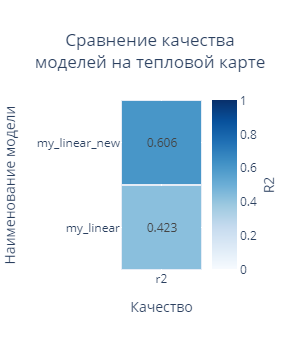

In [48]:
heat = go.Heatmap(z = r2_df_new,
                  x = r2_df_new.columns,
                  y = r2_df_new.index,
                  zmin = 0, 
                  zmax = 1,
                  texttemplate='%{z:.3f}',
                  xgap = 2,
                  ygap = 2,
                  colorscale = 'Blues',
                  colorbar = dict(title='R2', titleside='right', len=1.11, thickness=25, x=1.0))

fig=go.Figure(data=[heat])

fig.update_layout(title={'text': 'Сравнение качества<br>моделей на тепловой карте',
                         'y':0.87,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},                  
                  width = 300,
                  height = 350,                  
                  xaxis_title='Качество',
                  yaxis_title='Наименование модели',
                  autosize = False)
fig.show('png')

- Качество улучшилось

#### Сравнение количественных распределений данных между целевым признаком и его предсказаниями

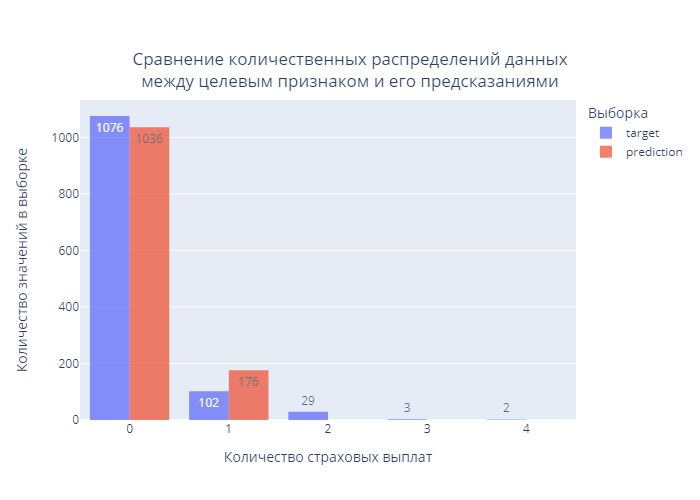

In [49]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=target_test, name='target', texttemplate='%{y}', histfunc='count'))
fig.add_trace(go.Histogram(x=pred_my_linear_new, name='prediction', texttemplate='%{y}', histfunc='count'))

fig.update_traces(opacity=0.75)

fig.update_layout(title={'text': 'Сравнение количественных распределений данных<br>между целевым признаком и его предсказаниями',
                         'y':0.87,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  legend_title=dict(text='Выборка'),
                  
                  xaxis_title='Количество страховых выплат',
                  yaxis_title='Количество значений в выборке')

fig.show('png')

- модель предсказывает только значения 0 и 1, т.к. в целевом признаке их значительно больше, чем остальных

### Визуализация разницы между целевым признаком и предсказаниями

Сбросим индексы

In [50]:
target_test = target_test.reset_index(drop=True)
pred_my_linear_new = pred_my_linear_new.reset_index(drop=True)

Для визуализации разницы между целевым признаком и предсказаниями построим точечные диаграммы.

График интерактивный. Для анализа необходимо масштабировать и перемещать.

In [51]:
data_test_markers = []

In [52]:
for sel, col, mode in zip(['target_test', 'pred_my_linear_new'],
                          ['lightseagreen', 'deeppink'],
                          ['markers', 'lines']):
    
    locals()[f'{sel}_fig'] = go.Scatter(x=locals()[sel].index,
                                        y=locals()[sel],
                                        mode=mode,
                                        opacity=0.7,
                                        name=sel,
                                        marker=dict(color=col, opacity=0.7))
    data_test_markers.append(locals()[f'{sel}_fig'])

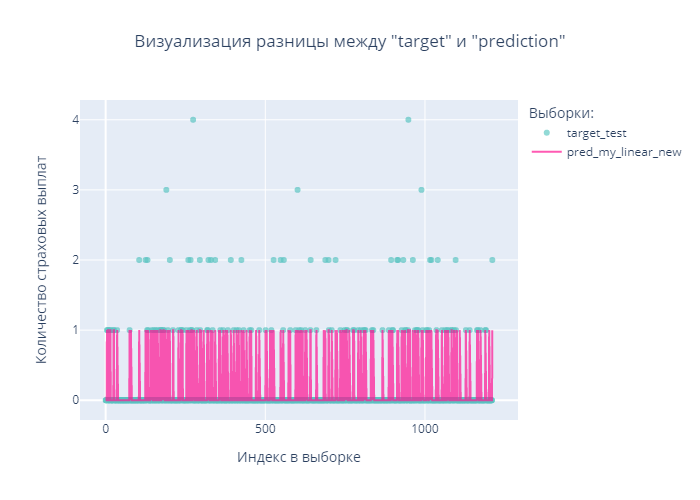

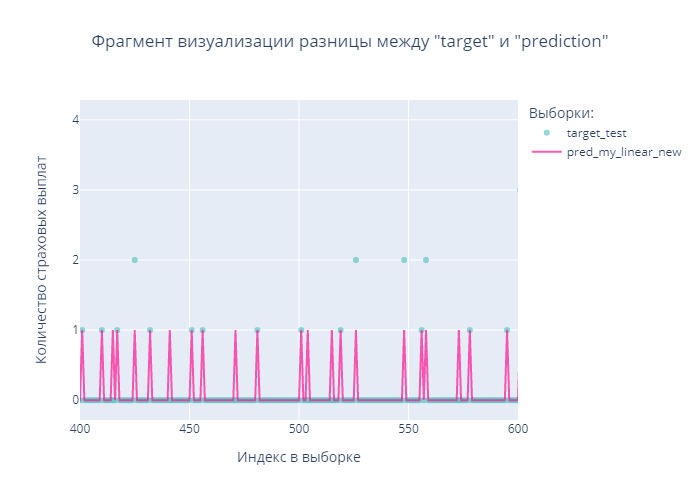

In [53]:
fig = go.Figure(data=data_test_markers)

fig.update_layout(title={'text': 'Визуализация разницы между "target" и "prediction"',
                         'y':0.93,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  xaxis_title='Индекс в выборке',
                  yaxis_title='Количество страховых выплат',
                  legend_title='Выборки:')

fig.update_yaxes(dtick=1)

fig.show('png')

fig.update_layout(title={'text': 'Фрагмент визуализации разницы между "target" и "prediction"',
                         'y':0.93,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})

fig.update_xaxes(range=[400, 600])

fig.show('png')

- подтвердились выводы, сделанные ранее, значения больше 1 модель не предсказывает
- на примерно 15% данных модель ошибается 10 раз

### Анализ отклонений предсказаний от значений целевого признака

Запишем отклонения предсказаний от значений целевого признака в отдельную переменную.

In [54]:
deviation = target_test-pred_my_linear_new

Доля ненулевых отклонений (далее просто отклонений) предсказаний от значений целевого признака

In [55]:
(deviation != 0).mean().round(2)

0.06

Количество отклонений предсказаний от значений целевого признака

In [56]:
deviation.loc[deviation != 0].count()

74

Для сравнения количества отклонений предсказаний от значений целевого признака построим столбчатые диаграммы.

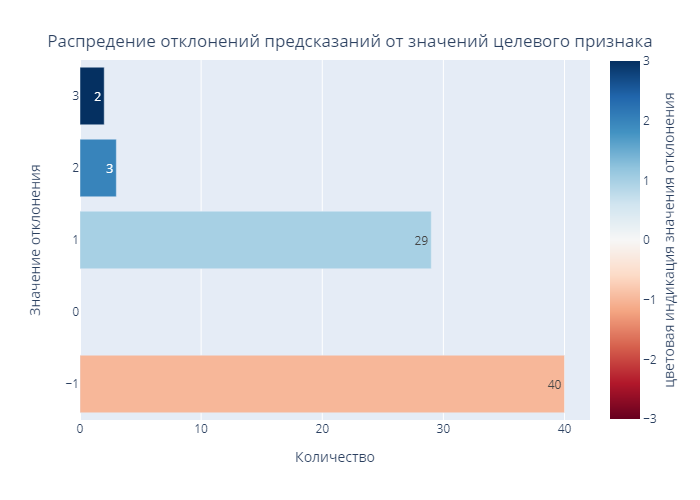

In [57]:
fig = px.bar(y=deviation.loc[deviation != 0].value_counts().index,
             x=deviation.loc[deviation != 0].value_counts(),
             orientation='h',
             text_auto=True,
             color=deviation.loc[deviation != 0].value_counts().index,
             color_continuous_midpoint = 0,
             color_continuous_scale=px.colors.sequential.RdBu)

fig.update_traces(textangle=0)

fig.update_layout(title={'text': 'Распредение отклонений предсказаний от значений целевого признака',
                         'y':0.93,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  coloraxis_colorbar=dict(title = dict(text='цветовая индикация значения отклонения', side='right'),
                                          len=1.05),
                  
                  xaxis_title='Количество',
                  yaxis_title='Значение отклонения')

fig.show('png')

- Максимальное количество раз модель ошибалась в меньшую сторону.

### Влияние признаков на предсказания

Сбросим индексы для переменной `features_test`

In [58]:
features_test = features_test.reset_index(drop=True)

Далеее для интерпретации результатов будем использовать модуль `shap`, позволяющий получить информацию о важности признаков и визуализировать её.

#### Пояснение предсказаний модели с помощью SHAP

In [59]:
explainer = shap.explainers.Linear(model_linear, features_test)
shap_values = explainer(features_test)

#### Зависимость вклада в предсказания модели от каждого признака на точечных диаграммах

Построим точечные диаграммы зависимости предсказаний модели от каждого признака с общей осью $y$, где $y$ - предсказания модели 

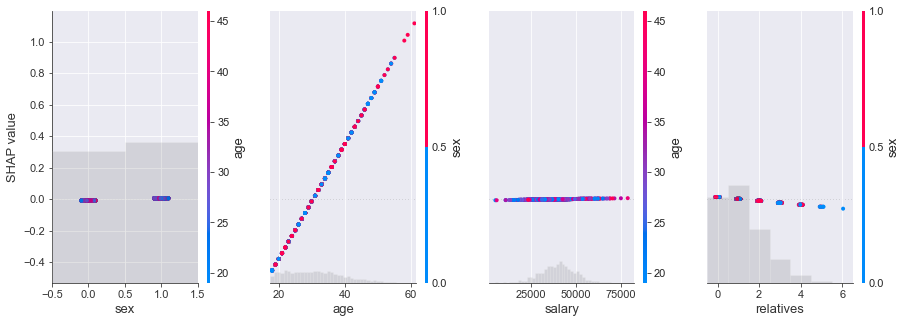

In [60]:
inds = shap.utils.potential_interactions(shap_values[:, 'age'], shap_values)
shap.plots.scatter(shap_values, color=shap_values[:, inds])

- признаки `sex`, `salary`, `relatives` незначительно влияют на предсказания модели по сравнению с признаком `age`
- с увеличением возраста (признак `age`) предсказания становятся ближе к значению 1

Посмотрим на каждый признак в отдельности.

Построим точечные диаграммы зависимости предсказаний модели от каждого признака с индивидуальной осью $y$, где $y$  - предсказания модели.

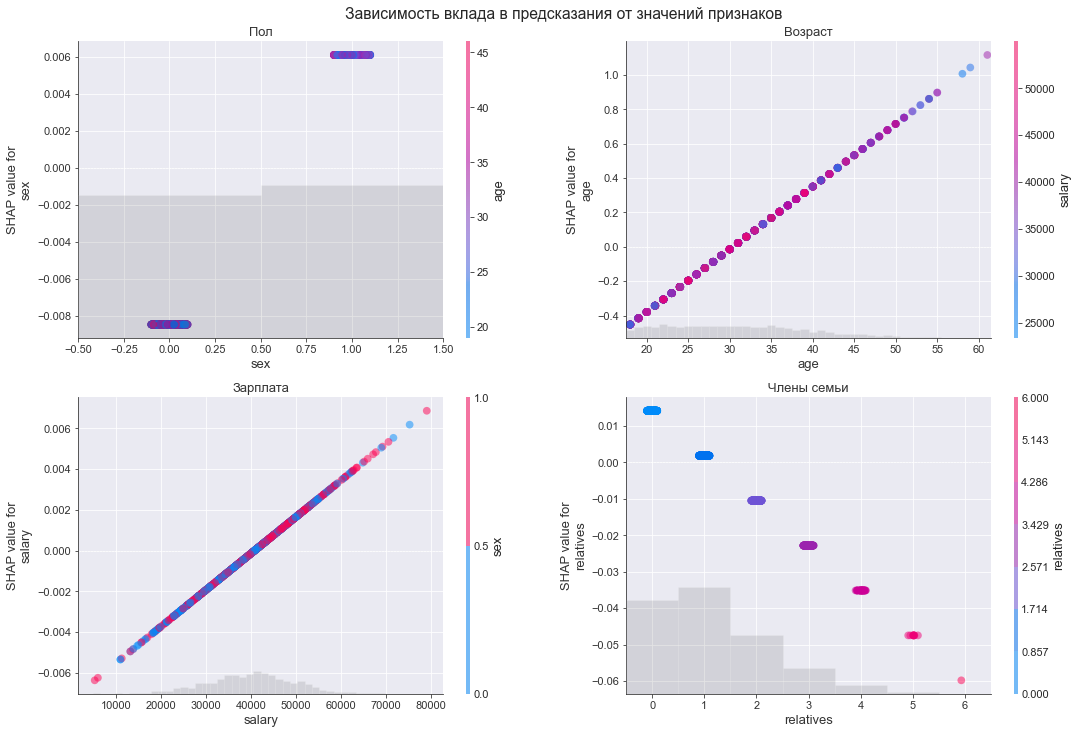

In [61]:
columns = features_test.columns
features_title = ['Пол', 'Возраст', 'Зарплата', 'Члены семьи']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.ravel()

fig.suptitle('Зависимость вклада в предсказания от значений признаков', y=.92)

inds = shap.utils.potential_interactions(shap_values[:, 'age'], shap_values)

for i in range(len(columns)):
    inds = shap.utils.potential_interactions(shap_values[:, i], shap_values)
    shap.plots.scatter(shap_values[:, i],
                       ax=axes[i],
                       show=False,
                       title=features_title[i],
                       color=shap_values[:,inds[i]],
                       alpha=0.5,
                       dot_size=60);

- налицо работа по линейному закону
- т.к. целевой признак целочисленный, а признаки `sex`, `salary`, `relatives` влияют на предсказания в районе нуля (точно внутри диапазона (-0.5, 0.5), то влияниями данных признаков на предсказания можно пренебречь - они все предсказывают 0
- данный проект учебный, поэтому обнаружено слабое влияние вышеперечисленных признаков на результаты предсказаний, уверен, в реальной жизни данные признаки вносят больший вклад

#### Cводный график важности признаков

Построим сводный график важности признаков.
<br>Пояснения к графику:
- по оси x значения вклада в предсказания (значения Шепли),
- признаки расположены на оси y по мере уменьшения их важности,
- каждая точка – отдельное наблюдение,
- чем толще линия на графике, тем больше таких точек наблюдения,
- цветом обозначены значения соответствующего признака: высокие – красным , низкие – синим.

Дополнительно с основному сводному графику добавим столбчатую диаграмму средних значений вкладов признаков в предсказания.

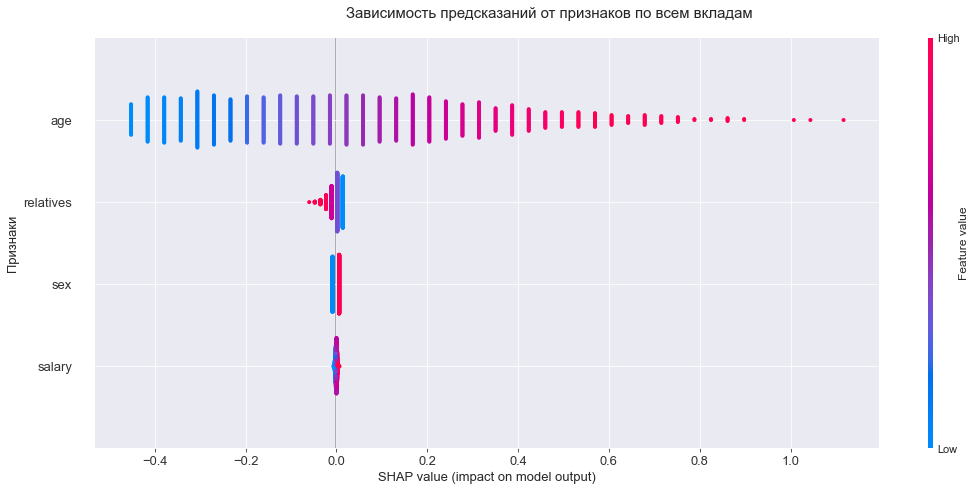

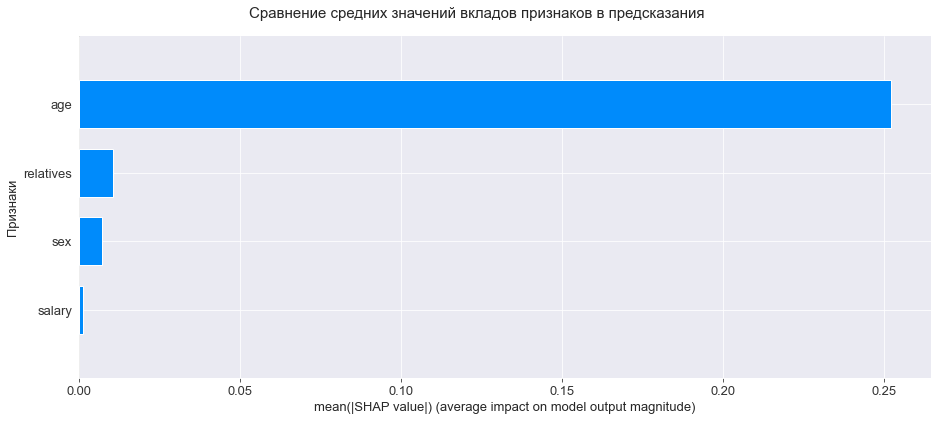

In [62]:
fig, _ = plt.subplots()

fig.suptitle('Зависимость предсказаний от признаков по всем вкладам', y=.97, fontsize=15)

shap.summary_plot(shap_values, features_test, plot_size=(15,7), show=False)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Признаки', fontsize=13)

plt.show()

fig, _ = plt.subplots()

fig.suptitle('Сравнение средних значений вкладов признаков в предсказания', y=.97, fontsize=15)

shap.summary_plot(shap_values, features_test, plot_type="bar", plot_size=(13,6), show=False)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Признаки', fontsize=13)

plt.show()

Опишем выводы, дополняющие ранее сделанные наблюдения:
- чем меньше возраст, тем ниже значение вклада в предсказания,
- чем меньше членов семьи, тем выше значение вклада в предсказания,
- пол зашифрованный как "0" занижает вклад в предсказания, защифрованный как "1" - завышает,
- чем меньше зарплата, тем ниже значение предсказания,
- зарплата оказывает самое незначительное влияние на предсказания (повторюсь, уверен, что в реальной жизни это не так).

<center><ins>Значимость признаков в порядке убывания:

| <font size="2">**Признак**|
| :---: |
|<font size="2">age|    
|<font size="2">relatives|
|<font size="2">sex|
|<font size="2">salary|

#### Анализ признаков по значениям ошибок в предсказаниях

##### Подготовка данных

Сохраним список столбцов признаков в отдельную переменную

In [63]:
feat_cols = features_test.columns

Сохраним список столбцов вкладов признаков в предсказание в отдельную переменную

In [64]:
shap_cols = [x+'_shap' for x in feat_cols]

Создадим датасет `shap_values_df` из значений вкладов признаков в предсказание

In [65]:
shap_values_df = pd.DataFrame(shap_values.values, columns=shap_cols)

Создадим датасет `deviation_df` из значений отклонений предсказаний от значений целевого признака

In [66]:
deviation_df=pd.DataFrame(deviation, columns=['deviation'])

Датасеты `features_test`, `shap_values_df` и `deviation_df` методом `concat()` последовательно объединим по горизонтали (один за другим).

In [67]:
test_shap = pd.concat([features_test, shap_values_df, deviation_df],axis=1)

Индексы объектов с максимальной ошибкой<br>(в качестве максимальной ошибки примем значения отклонения предсказания от целевого признака **2** и **3**, вычисленные в пункте **7.4**).

In [68]:
max_deviation_i = list(test_shap[test_shap['deviation'].isin([2,3])].index)
max_deviation_i

[190, 274, 601, 948, 989]

##### Пояснения к графикам аддитивной силы

Визуализируем заданные значения `SHAP` с помощью графика аддитивной силы.<br>График показывает, как разные признаки влияют на итоговое предсказание модели.
- `base value` (базовое значение) – среднее значение, полученное при обучении;
- жирным выделено полученное значение `base value`;
- если значение вклада положительное (красный цвет), то оно увеличивает предсказание, если отрицательное (синий цвет) - уменьшает;
- графики выполняются как интерактивными, так и в формате библиотеки `matplotlib`, в зависимости от задачи визуализации.

##### Графики аддитивной силы для признаков с максимальными ошибками

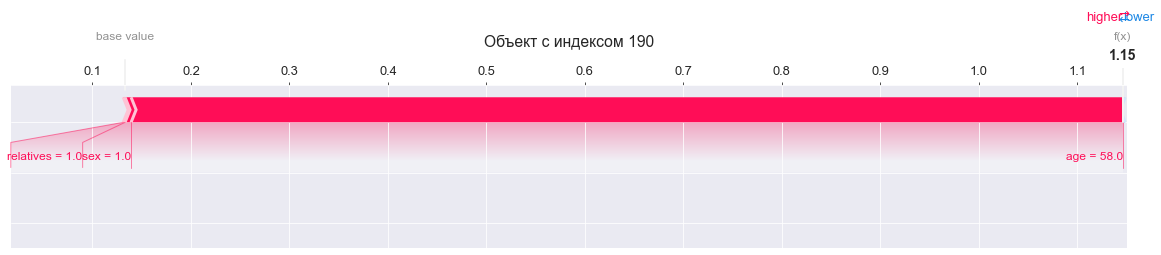

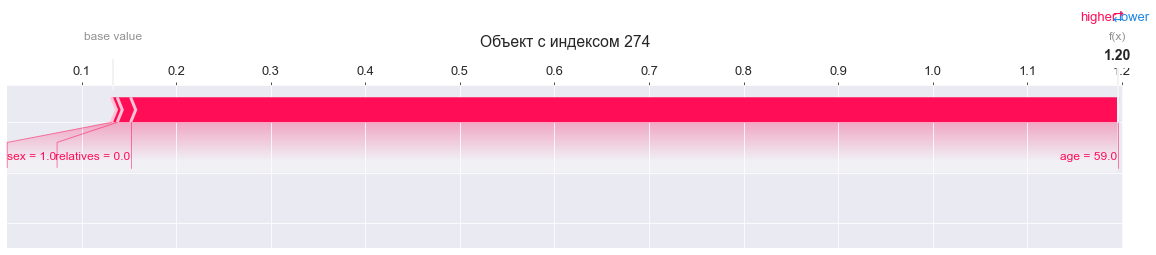

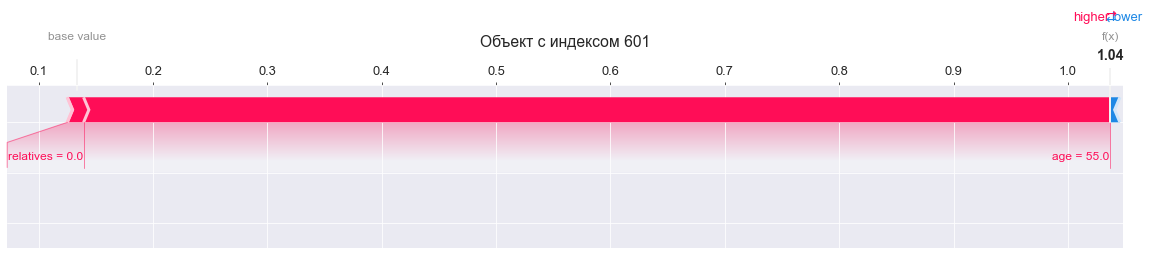

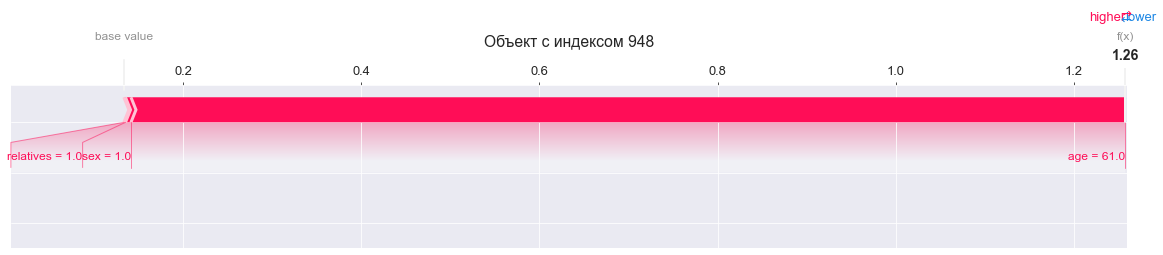

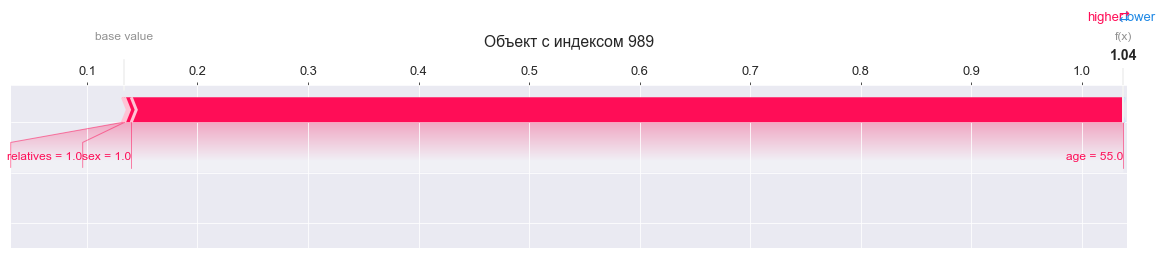

In [69]:
for i in max_deviation_i:  
   
    shap.force_plot(explainer.expected_value,
                    test_shap[shap_cols].values[i,:],
                    test_shap[feat_cols].iloc[i,:],
                    matplotlib=True, show=0)
    
    plt.title(f'Объект с индексом {i}', y=1.2)

Влиянение заработной платы посмотрим на примере одного из объектов с большой ошибкой на интерактивном графике, добавив функцию `shap.initjs()`.

In [70]:
shap.initjs()
shap.force_plot(explainer.expected_value,
                test_shap[shap_cols].values[190,:],
                test_shap[feat_cols].iloc[190,:])

- влияние заработной платы минимальное

Посмотрим разброс значений зарплат среди объектов с максимальной ошибкой.

In [71]:
dev_salary = test_shap.loc[max_deviation_i,['salary', 'salary_shap', 'deviation']].sort_values(by='salary', ascending=False)

In [72]:
cm = sns.light_palette('royalblue', as_cmap=True)
dev_salary.style.background_gradient(cmap=cm, subset=['salary', 'salary_shap'])

,salary,salary_shap,deviation
601,41600.000000,0.000146,2
948,39600.000000,-0.000213,3
989,33100.000000,-0.001379,2
274,29600.000000,-0.002007,3
190,28300.000000,-0.002241,2


Средняя зарплата в исходном датасете.

In [73]:
round(df['salary'].mean())

39896

Посмотрим разброс значений всех признаков среди объектов с максимальной ошибкой.

In [74]:
dev_color = test_shap.loc[max_deviation_i].sort_values(by='deviation', ascending=False)

In [75]:
cm = sns.light_palette('royalblue', as_cmap=True)
dev_color.style.background_gradient(cmap=cm, subset=['sex', 'sex_shap'])

,sex,age,salary,relatives,sex_shap,age_shap,salary_shap,relatives_shap,deviation
274,1,59.000000,29600.000000,0,0.006122,1.043644,-0.002007,0.014185,3
948,1,61.000000,39600.000000,1,0.006122,1.116601,-0.000213,0.001850,3
190,1,58.000000,28300.000000,1,0.006122,1.007166,-0.002241,0.001850,2
601,0,55.000000,41600.000000,0,-0.008454,0.897731,0.000146,0.014185,2
989,1,55.000000,33100.000000,1,0.006122,0.897731,-0.001379,0.001850,2


Закономерности при анализе признаков с максимальными ошибками модели:
- возраст 55-61 год,
- пол, закодированный как 1, чаще даёт большую ошибку,
- пол, закодированный как 1, вносит отрицательный вклад в предсказание с большой ошибкой,
- число родственников 0-1
- зарплаты близки к среднему значению по исходному датасету

Построим аналогичный график для произвольного объекта.

Выберем случайный индекс (`i_r` - index random) при помощи функции `randint` из библиотеки `random`, предварительно применив функцию начального числа `seed` для неизменности полученного результата после перезагрузки ядра ноутбука.

In [76]:
random.seed(13)
i_r = random.randint(0,len(test_shap))
i_r

530

In [77]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap[shap_cols].values[i_r,:], test_shap[feat_cols].iloc[i_r,:])

In [78]:
print('Вклады в предсказание:  "sex"  {:.3f}, "age" {:.3f}, "salary" {:.3f}, "relatives" {:.3f}'
      .format(*shap_values.values[i_r]))

Вклады в предсказание:  "sex"  0.006, "age" -0.197, "salary" 0.000, "relatives" 0.014


##### Графики аддитивной силы для признаков с популярными ошибками

Построим графики аддитивной силы для самых популярных отклонений: `-1` и `1`.

- Выполним на первом графике визуализацию вкладов сразу всех объектов с ошибкой `-1`.
- Выполним на втором графике визуализацию вкладов сразу всех объектов с ошибкой `1`.

Мы буквально переворачиваем график, полученный выше, на 90 градусов, и повторяем операцию для каждого наблюдения, а затем соединяем всё в один. Это позволяет увидеть интерпретации сразу для каждого наблюдения в датасете.

- Графики выполним в интерактивном формате `javascript`, добавив функцию `shap.initjs()`.
- Для анализа поочередно выбираются и сравниваются признаки в левой центральной части графиков и применяется тип сортировки объектов в признаках в верхней центральной части графиков.

Признаки с популярной отрицательной ошибкой.

In [79]:
test_shap_dev_negative = test_shap.loc[test_shap['deviation'] == -1]
shap.initjs()
shap.force_plot(explainer.expected_value,
                test_shap_dev_negative[shap_cols].values,
                test_shap_dev_negative[feat_cols])

Признаки с популярной положительной ошибкой.

In [80]:
test_shap_dev_positive = test_shap.loc[test_shap['deviation'] == 1]
shap.initjs()
shap.force_plot(explainer.expected_value,
                test_shap_dev_positive[shap_cols].values,
                test_shap_dev_positive[feat_cols])

<ins>Возраст:
- для обоих случаев возраст завышает предсказание,
- с увеличением возраста вклад растет,
- вклад возраста в предсказания с положительными ошибками выше.

<ins>Количество членов семьи:
- от 0 до 1 члена семьи - наблюдается завышение предсказания,
- выше 1 члена семьи - занижение,
- в целом, с увеличением количества членов семьи вклад падает.

<ins>Пол:
- пол, закодированный как 1, вносит больший вклад, причём завышает,
- пол, закодированный как 0, занижает.

<ins>Зарплата:
- заплаты ниже средней занижают,
- зарплаты выше средней завышают.

## Выводы

Для компании «Хоть потоп»:
- проведено EDA исследование данных,
- данные обработаны для машинного обучения,
- разработан метод преобразования данных, для их шифровки без изменения качества,
- проведено машинное обучение для проверки неизменности качества,
- проведена интерпретация результатов машинного обучения, по результатам которой сделаны выводы и внесены необходимые корректировки.